The goal here is to create an essemble model for 15 scene classication task

In [45]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1,l1_l2,l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import he_uniform,he_normal
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from shutil import copy2
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import VotingClassifier
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.models import load_model
# from vis.utils import utils
from tensorflow.keras import activations 
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from tqdm import tqdm

##### 1. Data preparation

In [48]:
folder_names=os.listdir("/home/kashraf/fall2021_coursework/Neural Nets/Assignment2/train_validation/train")
train_data_dir ="/home/kashraf/fall2021_coursework/Neural Nets/Assignment2/train_validation/train/"
validation_data_dir = "/home/kashraf/fall2021_coursework/Neural Nets/Assignment2/train_validation/validation/"

img_shape=64
def data_loader(path,folder,label):
    filenames=os.listdir(path+folder)
    images=[]
    labels=[label]*len(filenames)
    for file in filenames:
        img=cv2.imread(path+folder+"/"+file)
        img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img=cv2.resize(img,(img_shape,img_shape))
        images.append(img)
    return images,labels

In [49]:
x_train,y_train=[],[]
for label,file in tqdm(enumerate(folder_names)):
    x_train.append(data_loader(path=train_data_dir,folder=file,label=label)[0])
    y_train.append(data_loader(path=train_data_dir,folder=file,label=label)[1])
    
x_test,y_test=[],[]
for label,file in tqdm(enumerate(folder_names)):
    x_test.append(data_loader(path=validation_data_dir,folder=file,label=label)[0])
    y_test.append(data_loader(path=validation_data_dir,folder=file,label=label)[1])

    

15it [00:04,  3.44it/s]
15it [00:01, 11.16it/s]


### 3. Preprocess the data

In [50]:
import random
x_train,y_train=np.concatenate(x_train)/255,np.concatenate(y_train)
x_test,y_test=np.concatenate(x_test)/255,np.concatenate(y_test)


index_train=list(range(x_train.shape[0]))
random.shuffle(index_train)
index_test=list(range(x_test.shape[0]))
random.shuffle(index_test)

## Reshape x_train,X_test to 2D and suffle

x_train=x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])[index_train]
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])[index_test]
y_train=y_train[index_train]
y_test=y_train[index_test]
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)


x_train shape: (4458, 4096)
x_test shape: (1362, 4096)
y_train shape: (4458,)
y_test shape: (1362,)


In [51]:
x1_train = x_train.reshape((-1, 64, 64))
y1_train = to_categorical(y_train)
y1_train.shape

(4458, 15)

In [55]:
num_classes = 15
img_rows, img_cols = 64,64
batch_size =32
# rescale=1./255
# home/kashraf/fall2021_cours
train_data_dir ="/home/kashraf/fall2021_coursework/Neural Nets/Assignment2/train_validation/train"
validation_data_dir = "/home/kashraf/fall2021_coursework/Neural Nets/Assignment2/train_validation/validation"

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      
      horizontal_flip=True,
      vertical_flip=True,
      )
validation_datagen = ImageDataGenerator()
 
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 4458 images belonging to 15 classes.
Found 1362 images belonging to 15 classes.


#### 2. Loading three models from assignment 2 ( ADam, RMSprop, SGD)


In [32]:
models_path= "/home/kashraf/fall2021_coursework/Neural Nets/Assignment2/"

path1 = models_path+"cnn_scene_adamv1.h5"
path2 = models_path+"RMS_Prop.h5"
path3 = models_path+"cnn_scene_SGDv2.h5"

In [56]:
model1 = load_model(path1, compile=True)
model2 = load_model(path2, compile=True)

model3 = load_model(path3, compile=True)



In [115]:
score1=model1.predict_classes(validation_generator)
score2=model2.predict_classes(validation_generator)
score3=model3.predict_classes(validation_generator)

In [156]:
score=np.array([score1,score2,score3])
# score=score.reshape(score.shape[1],score.shape[0])
score = score.T

In [160]:
# ensemble_score=np.amax(score,axis=1)
y_true=validation_generator.classes
report=classification_report(y_true,score3)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       114
           1       0.96      0.96      0.96       111
           2       0.91      0.51      0.66       121
           3       0.85      0.78      0.81       122
           4       0.80      0.82      0.81       125
           5       0.84      0.79      0.81        77
           6       0.81      0.97      0.88        75
           7       0.98      0.77      0.86        77
           8       0.77      0.91      0.84        79
           9       0.91      0.87      0.89        79
          10       0.70      0.95      0.80        77
          11       0.87      0.87      0.87        79
          12       0.74      0.97      0.84        78
          13       0.86      0.88      0.87        76
          14       0.76      0.88      0.81        72

    accuracy                           0.84      1362
   macro avg       0.84      0.85      0.84      1362
weighted avg       0.85   

In [162]:
scores = [max(list(s), key=list(s).count) for i,s in enumerate(score)]
report=classification_report(y_true,scores)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.56      0.69       114
           1       0.97      0.96      0.97       111
           2       0.85      0.47      0.61       121
           3       0.81      0.72      0.76       122
           4       0.62      0.70      0.66       125
           5       0.84      0.81      0.82        77
           6       0.77      1.00      0.87        75
           7       0.97      0.75      0.85        77
           8       0.71      0.90      0.79        79
           9       0.90      0.84      0.87        79
          10       0.67      0.92      0.78        77
          11       0.87      0.90      0.88        79
          12       0.62      0.96      0.75        78
          13       0.93      0.83      0.88        76
          14       0.70      0.79      0.74        72

    accuracy                           0.79      1362
   macro avg       0.81      0.81      0.79      1362
weighted avg       0.81   


 Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.56      0.69       114
           1       0.97      0.96      0.97       111
           2       0.85      0.47      0.61       121
           3       0.81      0.72      0.76       122
           4       0.62      0.70      0.66       125
           5       0.84      0.81      0.82        77
           6       0.77      1.00      0.87        75
           7       0.97      0.75      0.85        77
           8       0.71      0.90      0.79        79
           9       0.90      0.84      0.87        79
          10       0.67      0.92      0.78        77
          11       0.87      0.90      0.88        79
          12       0.62      0.96      0.75        78
          13       0.93      0.83      0.88        76
          14       0.70      0.79      0.74        72

    accuracy                           0.79      1362
   macro avg       0.81      0.81      0.79      1362

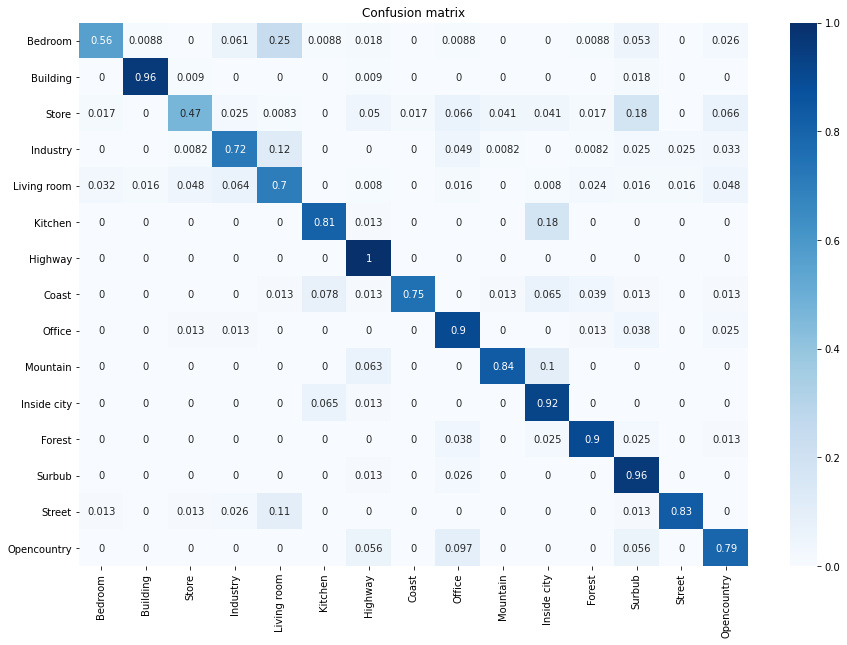

In [165]:
# y_pred=np.argmax(model.predict(validation_generator), axis=1)
# y_test=validation_generator.classes
import seaborn as sr
import pandas as pd

# y_predict,distances1=  face_recognition(x_test_recog,T_distance)
# accuracy=accuracy_score(y_test_recog,y_predict)
class_names=["Bedroom","Building","Store","Industry","Living room","Kitchen","Highway",'Coast',
             "Office","Mountain","Inside city","Forest","Surbub","Street","Opencountry"]
# report=classification_report(y_test,y_pred,target_names=class_names)

conf=confusion_matrix(y_true,scores,normalize="true")
conf_df=pd.DataFrame(conf, index=class_names, columns=class_names)
# print("\nFace  accuracy =",accuracy)
print("\n Classification report: \n",report)
fig=plt.figure(figsize=(15,10))
sr.heatmap(conf_df,annot=True,cmap="Blues")
plt.title("Confusion matrix")
plt.show()

In [136]:
report=classification_report(y_true,ensemble_score)
print(report)

# np.unique(ensemble_score, return_counts=True), np.unique(y_true, return_counts=True)

              precision    recall  f1-score   support

           0       0.26      0.26      0.26       114
           1       0.02      0.02      0.02       111
           2       0.00      0.00      0.00       121
           3       0.02      0.02      0.02       122
           4       0.06      0.06      0.06       125
           5       0.20      0.19      0.20        77
           6       0.27      0.33      0.30        75
           7       0.00      0.00      0.00        77
           8       0.03      0.04      0.04        79
           9       0.00      0.00      0.00        79
          10       0.01      0.01      0.01        77
          11       0.00      0.00      0.00        79
          12       0.00      0.00      0.00        78
          13       0.00      0.00      0.00        76
          14       0.35      0.32      0.34        72

    accuracy                           0.08      1362
   macro avg       0.08      0.08      0.08      1362
weighted avg       0.08   

## Now we train each model independently and merge their prediction

In [ ]:
models=[model1,model2,model3]
epochs=40
history =[0]*models
for i in range(3):
    history[i] = models[i].fit_generator(train_generator, 
                                         epochs = epochs,validation_data =validation_generator,
                                         callbacks=callbacks[i], verbose=1)


### evalauation

In [ ]:
    
# model.save("/home/kashraf/Felix_work2/modelsDL/stack_AlexNet_1_Epoch.h5")

# Evaluate the performance of our trained model
score_alpha= model[0].evaluate(x_test[0], y_test[0], verbose=1)
score_theta= model[1].evaluate(x_test[1], y_test[1], verbose=1)
score_beta= model[2].evaluate(x_test[2], y_test[2], verbose=1)

print('Test loss theta:', score_theta[0])
print('Test accuracy theta: ', score_theta[1])

print('Test loss alpha:', score_alpha[0])
print('Test accuracy alpha :', score_alpha[1])

print('Test loss beta:', score_beta[0])
print('Test accuracy beta:', score_beta[1])

In [52]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
model1= KerasClassifier(build_fn = fn_model1, epochs = 50)
model1._estimator_type = "classifier"

model2= KerasClassifier(build_fn = fn_model2, epochs = 50)
model2._estimator_type = "classifier"

model3= KerasClassifier(build_fn = fn_model3, epochs = 50)
model3._estimator_type = "classifier"

### Training the best model

#### 3. Creating essemble model

In [53]:
ensemble_clf = VotingClassifier(estimators = [('model1', model1), ('model2', model2), ('model3', model3)], voting = 'soft')
ensemble_clf.fit(x1_train,y1_train)


NotImplementedError: Multilabel and multi-output classification is not supported.

In [21]:
train_generator.filenames

['00/1.jpg',
 '00/10.jpg',
 '00/100.jpg',
 '00/101.jpg',
 '00/102.jpg',
 '00/103.jpg',
 '00/104.jpg',
 '00/105.jpg',
 '00/106.jpg',
 '00/107.jpg',
 '00/108.jpg',
 '00/109.jpg',
 '00/11.jpg',
 '00/110.jpg',
 '00/111.jpg',
 '00/112.jpg',
 '00/113.jpg',
 '00/114.jpg',
 '00/115.jpg',
 '00/116.jpg',
 '00/117.jpg',
 '00/118.jpg',
 '00/119.jpg',
 '00/12.jpg',
 '00/120.jpg',
 '00/121.jpg',
 '00/122.jpg',
 '00/123.jpg',
 '00/124.jpg',
 '00/125.jpg',
 '00/126.jpg',
 '00/127.jpg',
 '00/128.jpg',
 '00/129.jpg',
 '00/13.jpg',
 '00/130.jpg',
 '00/131.jpg',
 '00/132.jpg',
 '00/133.jpg',
 '00/134.jpg',
 '00/135.jpg',
 '00/136.jpg',
 '00/137.jpg',
 '00/138.jpg',
 '00/139.jpg',
 '00/14.jpg',
 '00/140.jpg',
 '00/141.jpg',
 '00/142.jpg',
 '00/143.jpg',
 '00/144.jpg',
 '00/145.jpg',
 '00/146.jpg',
 '00/147.jpg',
 '00/148.jpg',
 '00/149.jpg',
 '00/15.jpg',
 '00/150.jpg',
 '00/151.jpg',
 '00/152.jpg',
 '00/153.jpg',
 '00/154.jpg',
 '00/155.jpg',
 '00/156.jpg',
 '00/157.jpg',
 '00/158.jpg',
 '00/159.jpg',
 '0